In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.optim import Adam
from torch.nn.functional import mse_loss
from torchvision import transforms
from torchvision.models import vgg19, VGG19_Weights



In [2]:
vgg_19 = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features

In [3]:
transformations = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor()
])

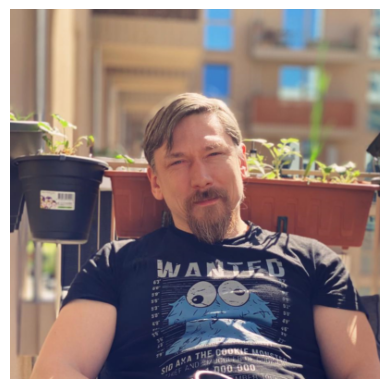

In [4]:
content_img = Image.open("sven_balkon_close.png").convert('RGB')
content_img = transformations(content_img)
plt.imshow(content_img.permute(1,2,0))
plt.axis(False)
plt.show()

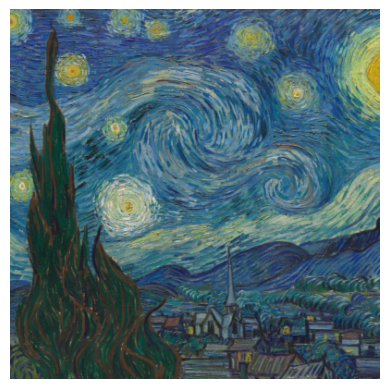

In [5]:
style_img = Image.open("the_starry_night.png").convert('RGB')
style_img = transformations(style_img)
plt.imshow(style_img.permute(1,2,0))
plt.axis(False)
plt.show()

In [6]:
feature_layers = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
}

In [7]:
def extract_features(image, model, layers=feature_layers):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [8]:
content_img_features = extract_features(content_img, vgg_19)
style_img_features = extract_features(style_img, vgg_19)

In [9]:
def calc_gram_matrix(features):
    n_channels, height, width = features.size()
    features_reshaped = features.view(n_channels, height * width)
    gram = torch.mm(features_reshaped, features_reshaped.t())
    return gram.div(n_channels * height * width)

In [10]:
style_features_gram_matrix = {layer: calc_gram_matrix(style_img_features[layer]) for layer in style_img_features} 

In [11]:
weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.9,
    'conv3_1': 0.8,
    'conv4_1': 0.7,
 #   'conv4_2': 1.0,
    'conv5_1': 0.6
}

In [12]:
LEARNING_RATE = 0.002
EPOCHS = 300 

In [13]:
target = content_img.clone().requires_grad_(True)
optimizer = Adam([target], lr=LEARNING_RATE)

In [14]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(f'The transfer learning is running on {device}')
vgg = vgg_19.to(device)
target = target.to(device)

The transfer learning is running on cpu


In [15]:
for i in range(EPOCHS):

    target_features = extract_features(target, vgg)

    content_loss = mse_loss(target_features['conv4_2'], content_img_features['conv4_2'].to(device))

    style_loss = 0

    for layer in weights:

        target_feature = target_features[layer]
        target_gram_matrix = calc_gram_matrix(target_feature)
        style_gram_matrix = style_features_gram_matrix[layer]

        layer_loss = mse_loss(target_gram_matrix, style_gram_matrix) * weights[layer]

        style_loss += layer_loss

    total_loss = 3000000 * style_loss + content_loss

    if (i + 1) % 10 == 0:
        print(f'Epoch {i + 1}:, Style loss: {style_loss}, Content loss: {content_loss}')

    optimizer.zero_grad()

    total_loss.backward(retain_graph=True)

    optimizer.step()

Epoch 10:, Style loss: 1.7589019307706621e-06, Content loss: 1.1691604852676392
Epoch 20:, Style loss: 7.022767363196181e-07, Content loss: 1.4764341115951538
Epoch 30:, Style loss: 4.7497397304141487e-07, Content loss: 1.390701413154602
Epoch 40:, Style loss: 4.000143576377013e-07, Content loss: 1.27397882938385
Epoch 50:, Style loss: 3.5940550446866837e-07, Content loss: 1.1896196603775024
Epoch 60:, Style loss: 3.3492395346002013e-07, Content loss: 1.1240837574005127
Epoch 70:, Style loss: 3.162015502766735e-07, Content loss: 1.079408049583435
Epoch 80:, Style loss: 3.0125130479063955e-07, Content loss: 1.046418309211731
Epoch 90:, Style loss: 2.8907035698466643e-07, Content loss: 1.0197442770004272
Epoch 100:, Style loss: 2.786947561617126e-07, Content loss: 0.9976353645324707
Epoch 110:, Style loss: 2.69519887297065e-07, Content loss: 0.9793511033058167
Epoch 120:, Style loss: 2.6137436748285836e-07, Content loss: 0.9636942148208618
Epoch 130:, Style loss: 2.541486878726573e-07, C

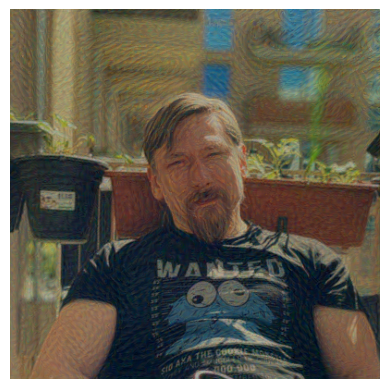

In [16]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
def tensor_to_image(tensor):
    image = tensor.clone().detach()
    image = image.cpu().numpy().squeeze()

    image = image.transpose(1,2,0)

    image *=  np.array(std) + np.array(mean)
    image = image.clip(0, 1)

    return image

img = tensor_to_image(target)
plt.imshow(img)
plt.axis(False)
plt.savefig('style_tranfer_the_starry_night.png')